In [1]:
!pip install -q scikit-optimize catboost imbalanced-learn lightgbm

In [2]:
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import GroupShuffleSplit, StratifiedKFold, train_test_split, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix, recall_score, precision_score
import joblib

In [ ]:
DATA_PATH = './Dementia Prediction Dataset.csv'
RANDOM_STATE = 42
TARGET = 'DEMENTED'
SUBJECT_ID = 'NACCID' 

In [4]:
def load_data(path):
    if not os.path.exists(path):
        raise FileNotFoundError(f"Data file not found at {path}. Upload it to Colab or set DATA_PATH correctly.")
    df = pd.read_csv(path)
    return df

In [75]:
NON_MEDICAL_WHITELIST = [
    # Subject demographics
    'BIRTHYR', 'BIRTHMO', 'SEX', 'HISPANIC', 'HISPOR', 'HISPORX',
    'RACE', 'RACEX', 'RACESEC', 'RACESECX', 'RACETER', 'RACETERX',
    'EDUC', 'MARISTAT', 'PRIMLANG', 'PRIMLANX', 'RESIDENC', 'HANDED', 'NACCLIVS', 'INDEPEND',
    # Co-participant
    'INBIRYR', 'INBIRMO', 'INSEX', 'INHISP', 'INHISPOR', 'INHISPOX', 'INRACE', 'INRACEX', 'INRASEC', 'INRASECX', 'INRATER', 'INRATERX', 'INEDUC', 'INRELTO', 'INRELTOX', 'NEWINF',
    # Lifestyle
    'TOBAC30', 'TOBAC100', 'SMOKYRS', 'PACKSPER', 'QUITSMOK', 'ALCOCCAS', 'ALCFREQ',
    # Visit metadata
    'NACCVNUM', 'NACCNVST', 'NACCAVST', 'NACCDAYS', 'NACCFDYS', 'PACKET', 'FORMVER', 'TELCOV', 'TELMOD',
    # Family history (non-genetic fields)
    'NACCFAM', 'NACCMOM', 'NACCDAD'
]

In [76]:
print('Loading data...')
df = load_data(DATA_PATH)
print('Rows:', len(df), 'Columns:', len(df.columns))

Loading data...
Rows: 195196 Columns: 1024


In [77]:
# Ensure target and subject id exist
if TARGET not in df.columns:
    raise KeyError(f"Target column '{TARGET}' not found in dataset.")
if SUBJECT_ID not in df.columns:
    raise KeyError(f"Subject ID column '{SUBJECT_ID}' not found in dataset.")

# Reduce to columns we care about (keep subject id and target)
available_features = [c for c in NON_MEDICAL_WHITELIST if c in df.columns]

if len(available_features) < len(NON_MEDICAL_WHITELIST):
    missing = set(NON_MEDICAL_WHITELIST) - set(available_features)
    print("Warning: These whitelist columns were missing and skipped:", missing)

print(f'Using {len(available_features)} non-medical features (of {len(NON_MEDICAL_WHITELIST)} whitelist)')

# Warn about missing whitelist columns
missing = set(NON_MEDICAL_WHITELIST) - set(available_features)
if missing:
    print('Warning: The following whitelist columns were not found in your CSV and will be skipped:')
    print(sorted(list(missing)))

keep_cols = [SUBJECT_ID, TARGET] + available_features
df = df[keep_cols].copy()

Using 55 non-medical features (of 55 whitelist)


Handle NACC special codes -> convert common missing codes to NaN

In [78]:
# Typical NACC codes: -4 = Not applicable, -1 or 9 = Unknown, 88/99 = other/missing depending on variable
NA_CODES = [-4, -1, 8, 9, 88, 95, 96, 97, 98, 99, 999]
for v in df.columns:
    if df[v].dtype.kind in 'biufc':
        df[v] = df[v].replace(NA_CODES, np.nan)
    else:
        # for object/string fields, keep as-is and handle missing later
        df[v] = df[v].replace([str(x) for x in NA_CODES], np.nan)

# Also treat target code '9' explicitly as NaN (unknown)
df[TARGET] = df[TARGET].replace(9, np.nan)

# Drop rows where target is missing
df = df[df[TARGET].notna()].copy()
print('After dropping unknown target, rows:', len(df))

After dropping unknown target, rows: 195196


Feature engineering

In [ ]:
# AGE if present; compute age-at-visit if possible using BIRTHYR and an approximate VISITYR if available.
# If NACCAGE exists, prefer it. Otherwise derive AGE from BIRTHYR with caveat.
if 'BIRTHYR' in df.columns and 'NACCFDYS' in df.columns:
    df['AGE'] = (df['NACCFDYS'] / 365.25) + (2023 - df['BIRTHYR'])
elif 'NACCAGE' in df.columns:
    df['AGE'] = df['NACCAGE']
else:
    df['AGE'] = np.nan

df['AGE_BIN'] = pd.cut(df['AGE'], bins=[0, 60, 70, 80, 120], labels=['<60', '60-70', '70-80', '80+'])

# Pack-years and simple booleans
if 'PACKSPER' in df.columns and 'SMOKYRS' in df.columns:
    df['PACK_YEARS'] = df['PACKSPER'] * df['SMOKYRS']
else:
    df['PACK_YEARS'] = np.nan

if 'TOBAC30' in df.columns and 'TOBAC100' in df.columns:
    df['EVER_SMOKE'] = ((df['TOBAC30'] == 1) | (df['TOBAC100'] == 1)).astype(int)
else:
    df['EVER_SMOKE'] = pd.Series([pd.NA] * len(df))

# Heavy alcohol heuristic
if 'ALCFREQ' in df.columns:
    # interpret codes: (user should adjust according to their codebook)
    # treat high frequency codes (e.g., weekly/daily) as heavy
    df['HEAVY_ALCOHOL'] = df['ALCFREQ'].apply(lambda x: 1 if (pd.notna(x) and float(x) >= 5) else 0).astype('Int64')
else:
    df['HEAVY_ALCOHOL'] = pd.Series([pd.NA] * len(df))

# Years in study
if 'NACCDAYS' in df.columns:
    df['YEARS_IN_STUDY'] = df['NACCDAYS'] / 365.25
else:
    df['YEARS_IN_STUDY'] = np.nan

# Lives alone bool from NACCLIVS (if 1 = lives alone in your version)
if 'NACCLIVS' in df.columns:
    df['LIVES_ALONE'] = df['NACCLIVS'].apply(lambda x: 1 if x == 1 else 0).astype('Int64')
else:
    df['LIVES_ALONE'] = pd.Series([pd.NA] * len(df))

df['MARRIED'] = (df['MARISTAT'] == 1).astype('Int64')  # 1 = married

# Education level (simplify)
df['HIGH_EDUC'] = (df['EDUC'] >= 16).astype('Int64')  # college+

# Family history of dementia
df['FAM_DEMENTIA'] = ((df['NACCMOM'] == 1) | (df['NACCDAD'] == 1)).astype('Int64')

df['AGE_EDUC_INTERACT'] = df['AGE'] * df['EDUC']
df['AGE_SMOKE_INTERACT'] = df['AGE'] * df['EVER_SMOKE']

# Final feature list (keep engineered features)
engineered_features = [
    'AGE', 'LIVES_ALONE', 'MARRIED', 'HIGH_EDUC',
    'EVER_SMOKE', 'PACK_YEARS', 'HEAVY_ALCOHOL',
    'YEARS_IN_STUDY', 'AGE_EDUC_INTERACT', 'AGE_SMOKE_INTERACT',
    'AGE_BIN'
]

existing_engineered = [c for c in engineered_features if c in df.columns]

print(f"Using {len(existing_engineered)} engineered features.")

FINAL_FEATURES = available_features + existing_engineered

print(f"Total final features: {len(FINAL_FEATURES)}")

for e in engineered_features:
    if e not in df.columns:
        df[e] = np.nan

Using 11 engineered features.
Total final features: 66


Final feature set building (numeric vs categorical)

In [ ]:
existing_features = [col for col in FINAL_FEATURES if col in df.columns]
missing_features = set(FINAL_FEATURES) - set(existing_features)

print(f"Using {len(existing_features)} features (of {len(FINAL_FEATURES)})")
if missing_features:
    print("Missing features (will be skipped):", sorted(missing_features))

Using 66 features (of 66)


In [81]:
from sklearn.model_selection import GroupShuffleSplit

X = df[FINAL_FEATURES].copy()
y = df[TARGET].astype(int)

print(y.value_counts(normalize=True))  # Check imbalance, e.g., 70% not demented

gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=RANDOM_STATE)
train_idx, test_idx = next(gss.split(X, y, groups=df[SUBJECT_ID]))

X_train, X_test = X.iloc[train_idx].reset_index(drop=True), X.iloc[test_idx].reset_index(drop=True)
y_train, y_test = y.iloc[train_idx].reset_index(drop=True), y.iloc[test_idx].reset_index(drop=True)

DEMENTED
0    0.704963
1    0.295037
Name: proportion, dtype: float64


In [82]:
numeric_features = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = X_train.select_dtypes(include=['object', 'category']).columns.tolist()

print(f"Numerical: {len(numeric_features)}, Categorical: {len(categorical_features)}")

Numerical: 54, Categorical: 12


Preprocessing pipeline

In [83]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features)
],remainder='passthrough')

In [84]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
import warnings; warnings.filterwarnings('ignore')
from catboost import CatBoostClassifier

models = {
    'XGBoost': XGBClassifier(
        tree_method='hist',
        eval_metric='logloss',
        random_state=RANDOM_STATE,
        n_estimators=300
    ),
    'LightGBM': LGBMClassifier(
        random_state=RANDOM_STATE,
        n_estimators=300,
        verbose=0
    ),
    'CatBoost': CatBoostClassifier(
        verbose=0,
        random_state=RANDOM_STATE,
        n_estimators=300
    )
}

param_grids = {
    'XGBoost': {
        'model__max_depth': [3, 4, 5, 6],
        'model__learning_rate': np.logspace(-3, -1, 5),
        'model__subsample': [0.6, 0.8, 1.0],
        'model__colsample_bytree': [0.6, 0.8, 1.0]
    },

    'LightGBM': {
        'model__num_leaves': [15, 31, 63],
        'model__learning_rate': np.logspace(-3, -1, 5),
        'model__subsample': [0.6, 0.8, 1.0]
    },

    'CatBoost': {
        'model__depth': [4, 5, 6, 7],
        'model__learning_rate': np.logspace(-3, -1, 5)
    }
}

Model pipeline + hyperparameter search

In [85]:
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from skopt import BayesSearchCV
from sklearn.metrics import (roc_auc_score, f1_score,
                             classification_report, confusion_matrix,
                             make_scorer)

best_models = {}
results = {}

for name, base_model in models.items():
    print(f"\n=== Tuning {name} ===")
    pipe = Pipeline(steps=[
        ('preprocess', preprocessor),
        ('model', base_model)
    ])
    search = RandomizedSearchCV(
        estimator=pipe,
        param_distributions=param_grids[name],
        n_iter=6,
        cv=2,
        scoring='roc_auc',
        n_jobs=-1,
        random_state=RANDOM_STATE,
        verbose=1
    )

    search.fit(X_train, y_train)
    best_models[name] = search.best_estimator_

    proba = search.best_estimator_.predict_proba(X_test)[:, 1]
    pred  = search.best_estimator_.predict(X_test)

    auc = roc_auc_score(y_test, proba)
    f1  = f1_score(y_test, pred)

    results[name] = {'auc': auc, 'f1': f1,"model": search.best_estimator_}

    print(f"{name} → AUC: {auc:.4f} | F1: {f1:.4f}")
    print(classification_report(y_test, pred))
    print("Confusion matrix:\n", confusion_matrix(y_test, pred))




=== Tuning XGBoost ===
Fitting 2 folds for each of 6 candidates, totalling 12 fits
XGBoost → AUC: 0.9434 | F1: 0.8307
              precision    recall  f1-score   support

           0       0.93      0.93      0.93     28023
           1       0.83      0.83      0.83     11415

    accuracy                           0.90     39438
   macro avg       0.88      0.88      0.88     39438
weighted avg       0.90      0.90      0.90     39438

Confusion matrix:
 [[26089  1934]
 [ 1931  9484]]

=== Tuning LightGBM ===
Fitting 2 folds for each of 6 candidates, totalling 12 fits


/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have va

LightGBM → AUC: 0.9441 | F1: 0.8309
              precision    recall  f1-score   support

           0       0.93      0.93      0.93     28023
           1       0.83      0.83      0.83     11415

    accuracy                           0.90     39438
   macro avg       0.88      0.88      0.88     39438
weighted avg       0.90      0.90      0.90     39438

Confusion matrix:
 [[26057  1966]
 [ 1904  9511]]

=== Tuning CatBoost ===
Fitting 2 folds for each of 6 candidates, totalling 12 fits
CatBoost → AUC: 0.9416 | F1: 0.8305
              precision    recall  f1-score   support

           0       0.93      0.93      0.93     28023
           1       0.82      0.84      0.83     11415

    accuracy                           0.90     39438
   macro avg       0.88      0.88      0.88     39438
weighted avg       0.90      0.90      0.90     39438

Confusion matrix:
 [[25975  2048]
 [ 1855  9560]]


In [88]:
best_model = results['LightGBM']['model']  # or dynamically find best_model_name
# The final estimator is inside the pipeline under 'model' step
final_estimator = best_model.named_steps['model']

print(final_estimator.get_params())

{'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0, 'importance_type': 'split', 'learning_rate': np.float64(0.03162277660168379), 'max_depth': -1, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 300, 'n_jobs': None, 'num_leaves': 63, 'objective': None, 'random_state': 42, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'subsample': 1.0, 'subsample_for_bin': 200000, 'subsample_freq': 0, 'verbose': 0}


In [87]:
best_model_name = max(results, key=lambda k: results[k]['auc'])

pre = results[best_model_name]['model'].named_steps['preprocess']

print("Final feature count:", len(final_features))
print(final_features)

Final feature count: 1555
['num__BIRTHYR' 'num__BIRTHMO' 'num__SEX' ... 'cat__AGE_BIN_70-80'
 'cat__AGE_BIN_80+' 'cat__AGE_BIN_<60']


In [89]:
best_name = max(results, key=lambda k: results[k]['auc'])
best_model = best_models[best_name]
print(f"Best model: {best_name} (AUC={results[best_name]['auc']:.4f})")

from sklearn.calibration import CalibratedClassifierCV

# Calibrate for better probabilities
calibrated = CalibratedClassifierCV(best_model, method='isotonic', cv=3)
calibrated.fit(X_train, y_train)

Best model: LightGBM (AUC=0.9441)


CalibratedClassifierCV(cv=3,
                       estimator=Pipeline(steps=[('preprocess',
                                                  ColumnTransformer(remainder='passthrough',
                                                                    transformers=[('num',
                                                                                   Pipeline(steps=[('imputer',
                                                                                                    SimpleImputer(strategy='median')),
                                                                                                   ('scaler',
                                                                                                    StandardScaler())]),
                                                                                   ['BIRTHYR',
                                                                                    'BIRTHMO',
                                                                                    'SEX',
                                                                                    'HISPANIC',
                                                                                    'HISPOR',
                                                                                    'RACE',
                                                                                    'RACESEC',
                                                                                    'RACETER',
                                                                                    'EDUC',
                                                                                    'MARISTAT',
                                                                                    'PRIMLANG',
                                                                                    'RESIDENC',
                                                                                    'HANDED',
                                                                                    'NACC...
                                                                                                   ('onehot',
                                                                                                    OneHotEncoder(handle_unknown='ignore',
                                                                                                                  sparse_output=False))]),
                                                                                   ['HISPORX',
                                                                                    'RACEX',
                                                                                    'RACESECX',
                                                                                    'RACETERX',
                                                                                    'PRIMLANX',
                                                                                    'INHISPOX',
                                                                                    'INRACEX',
                                                                                    'INRASECX',
                                                                                    'INRATERX',
                                                                                    'INRELTOX',
                                                                                    'PACKET',
                                                                                    'AGE_BIN'])])),
                                                 ('model',
                                                  LGBMClassifier(learning_rate=np.float64(0.03162277660168379),
                                                                 n_estimators=300,
                                                                 num_leaves=63,
                                                        

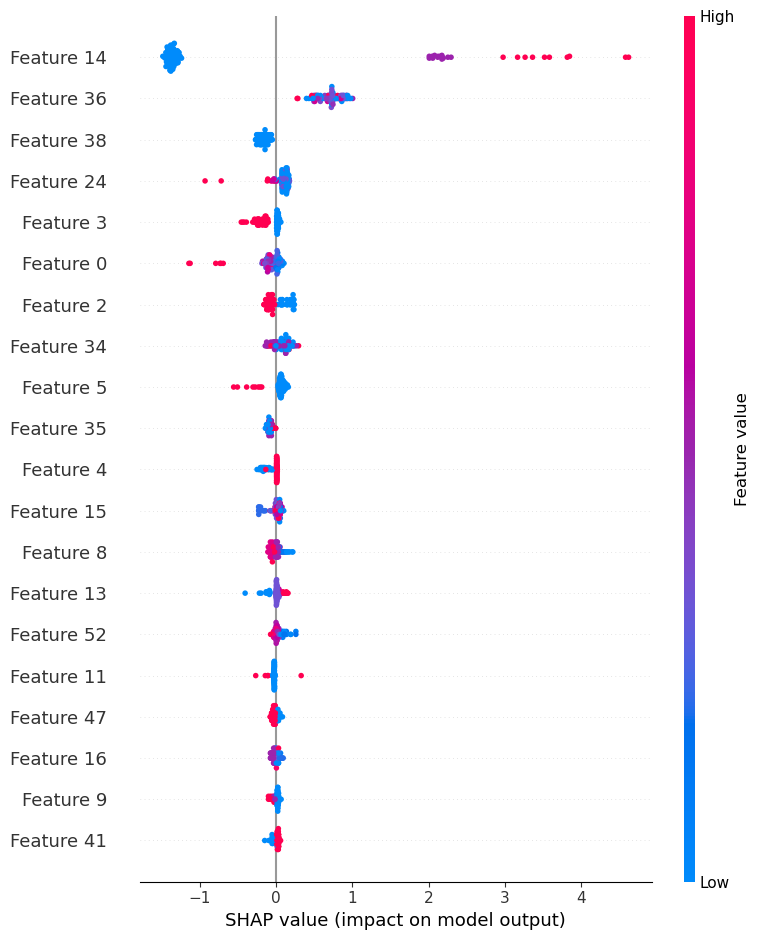

In [90]:
import shap

# Choose a model
chosen = results['LightGBM']['model']

# Extract preprocess + model separately
pre = chosen.named_steps['preprocess']
xgb = chosen.named_steps['model']

# Transform test data
X_test_t = pre.transform(X_test)

# Create SHAP explainer
explainer = shap.TreeExplainer(xgb)

# SHAP values for first 100 samples
X_sample = X_test_t[:100]
shap_values = explainer.shap_values(X_sample)

# Plot global importance
shap.summary_plot(shap_values, X_sample)

In [ ]:
from sklearn.inspection import permutation_importance

X_test_sample = X_test.sample(5000, random_state=42)
y_test_sample = y_test.loc[X_test_sample.index]

result = permutation_importance(
    calibrated,
    X_test_sample,
    y_test_sample,
    n_repeats=5,
    random_state=42,
    n_jobs=-1
)

importances = result.importances_mean
std = result.importances_std

for name, val, sd in zip(X_test.columns, importances, std):
    print(f"{name}: {val:.4f} (+/-{sd:.4f})")

/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have va

In [57]:
importance_df = pd.DataFrame({
    'feature': X_test.columns,
    'importance': importances,
    'std': std
}).sort_values(by='importance', ascending=False)

print(importance_df.head(20))  # top 20 features only

              feature  importance       std
19           INDEPEND     0.27168  0.003138
45           NACCAVST     0.00960  0.001748
46           NACCDAYS     0.00384  0.000941
44           NACCNVST     0.00268  0.000943
16           RESIDENC     0.00120  0.000283
33            INRELTO     0.00076  0.000196
12               EDUC     0.00076  0.000320
47           NACCFDYS     0.00068  0.000700
52            NACCFAM     0.00036  0.000674
60         PACK_YEARS     0.00032  0.000204
6                RACE     0.00024  0.000294
49            FORMVER     0.00024  0.000344
8             RACESEC     0.00024  0.000080
48             PACKET     0.00016  0.000150
39           PACKSPER     0.00012  0.000574
37           TOBAC100     0.00012  0.000160
2                 SEX     0.00012  0.000098
63  AGE_EDUC_INTERACT     0.00008  0.000204
21            INBIRMO     0.00004  0.000233
4              HISPOR     0.00004  0.000080


In [ ]:
import joblib
joblib.dump(search, "dementia_risk_model_final.pkl")
print("Final model saved!")

Final model saved!


In [66]:
import pandas as pd
import joblib

# Load the saved calibrated classifier
model = joblib.load("dementia_risk_model_final.pkl")

# Use a template row from your training/test set
template = X_test.iloc[[0]].copy()  # X_test must exist in this session

# Fill template with user input
user = {
    'AGE': 80, 'SEX': 2, 'EDUC': 10, 'MARISTAT': 1, 'RESIDENC': 1, 'INDEPEND': 1,
    'LIVES_ALONE': 1, 'MARRIED': 0, 'HIGH_EDUC': 0, 'EVER_SMOKE': 1, 'PACK_YEARS': 20,
    'ALCFREQ': 3, 'FAM_DEMENTIA': 1, 'NACCMOM': 1, 'NACCDAD': 0, 'HISPANIC': 0,
    'RACE': 1, 'PRIMLANG': 1, 'AGE_BIN': '70-80', 'HEAVY_ALCOHOL': 0,
    'YEARS_IN_STUDY': 5, 'AGE_EDUC_INTERACT': 780, 'AGE_SMOKE_INTERACT': 78
}

for col in template.columns:
    if col in user:
        template[col] = user[col]
    else:
        template[col] = 0  # default for missing features

# Predict
prob = model.predict_proba(template)[0,1] * 100
label = "At risk" if prob > 50 else "Not at risk"

print(f"Risk: {prob:.2f}%, Label: {label}")

Risk: 12.45%, Label: Not at risk
